<a href="https://colab.research.google.com/github/ab2gbl/ECG-detection/blob/main/QRS_detection/Test_of_QRS_detection_CNN%2BLSTM_50sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/

In [ ]:
!pip install wfdb numpy scipy matplotlib scikit-learn tensorflow


In [4]:
#!cp -r '/content/physionet.org' '/content/drive/MyDrive/Final project/dataset/physionet.org'

# Model Test

In [5]:
from tensorflow.keras.models import load_model
# Load the model later for inference
model = load_model("/content/drive/MyDrive/Final project/QRS detection/qrs_cnn_lstm_model_50sample.h5")

## functions used

In [6]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

def bandpass_filter(data, fs, lowcut=0.5, highcut=40.0, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered = signal.filtfilt(b, a, data)
    return filtered

def smooth_signal(data, window_size=5):
    # Smooth the signal using a moving average filter
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed

def normalize_signal(data):
    """
    Normalize the signal using z-score normalization.
    """
    return (data - np.mean(data)) / np.std(data)


In [7]:
def segment_signal(signal, window_size=50, overlap=40):
    """
    Segment the signal into fixed-length windows with a specified overlap.

    Args:
        signal (np.array): The input signal.
        window_size (int): Length of each segment (in samples).
        overlap (int): Number of overlapping samples between consecutive segments.

    Returns:
        tuple: (Array of segmented windows, Array of segment start indices)
    """
    segments = []
    segment_indices = []

    step = window_size - overlap  # Step size for sliding window
    for start in range(0, len(signal) - window_size + 1, step):
        end = start + window_size
        segments.append(signal[start:end])
        segment_indices.append(start)  # Store segment start position

    return np.array(segments), np.array(segment_indices)


In [29]:
import numpy as np

def label_segments(normalized_signal,segments, segment_starts, qrs_indices, window_size=50, overlap=25):
    """
    Label each segment as QRS (1) or non-QRS (0), ensuring an equal number of 0 and 1 labels.

    Args:
        segments (np.array): Array of segmented windows.
        segment_starts (np.array): Start indices of segments.
        qrs_indices (list): List of QRS indices (in samples).
        window_size (int): Length of each segment (in samples).
        overlap (int): Number of overlapping samples between consecutive segments.

    Returns:
        np.array: Array of labels (1 for QRS, 0 for non-QRS).
    """
    labels = np.zeros(len(segments), dtype=int)
    q_offset = 18  # Offset to cover full QRS complex

    # Label QRS segments
    for i, segment_start in enumerate(segment_starts):
        segment_end = segment_start + window_size

        # Check if any QRS index falls within this segment
        for r_peak in qrs_indices:
            q_start = r_peak - q_offset  # Approximate Q start
            s_end = r_peak + q_offset    # Approximate S end

            # Ensure q_start and s_end are within bounds
            q_start = max(0, q_start)
            s_end = min(len(normalized_signal) - 1, s_end)

            if segment_start <= q_start and segment_end >= s_end:
                labels[i] = 1
                break

    # Balance the dataset by randomly sampling non-QRS segments
    qrs_count = np.sum(labels == 1)  # Number of QRS segments
    non_qrs_indices = np.where(labels == 0)[0]  # Indices of non-QRS segments

    # Randomly sample non-QRS segments to match the number of QRS segments
    if len(non_qrs_indices) > qrs_count:
        sampled_non_qrs_indices = np.random.choice(non_qrs_indices, size=qrs_count, replace=False)
        labels[sampled_non_qrs_indices] = 0  # Ensure sampled non-QRS segments are labeled as 0
    else:
        print("Warning: Not enough non-QRS segments to balance the dataset.")

    return labels



## Testing

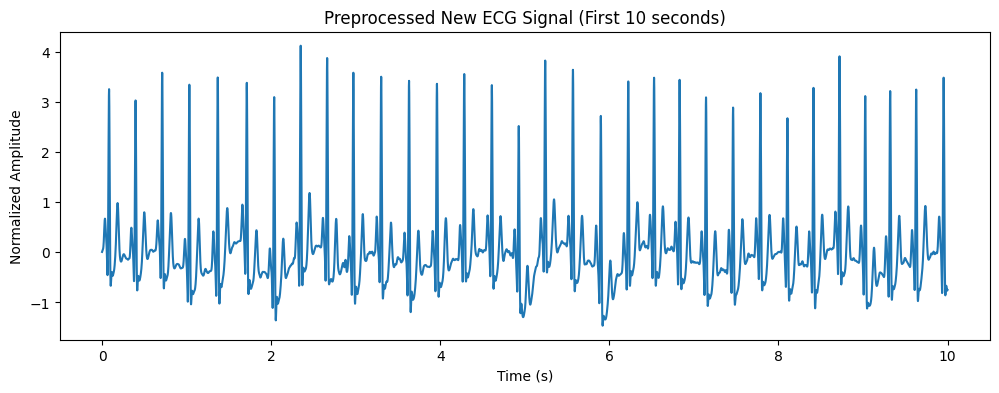

In [87]:
import wfdb
record_dir='/content/physionet.org/files/mitdb/1.0.0/'
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
new_record_name='101'
new_record_name =  record_dir + new_record_name  # Change this to the desired record
new_record = wfdb.rdrecord(new_record_name)
new_ecg_signal = new_record.p_signal[:, 0]  # Assuming single-channel ECG
fs = new_record.fs
new_annotation = wfdb.rdann(new_record_name, 'atr')
# Example usage
fs = 1000  # Sampling frequency in Hz
time_axis = np.arange(0, len(new_ecg_signal)) / fs  # Time axis in seconds

# Apply bandpass filter
new_filtered_signal = bandpass_filter(new_ecg_signal, fs)
# Optionally smooth the signal
new_smoothed_signal = smooth_signal(new_filtered_signal, window_size=5)
new_normalized_signal = normalize_signal(new_smoothed_signal)


# Visualize the preprocessed signal
import matplotlib.pyplot as plt
time_axis = [i / fs for i in range(len(new_normalized_signal))]
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:fs * 10], new_normalized_signal[:fs * 10])
plt.title("Preprocessed New ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.show()



In [88]:


# Example usage
window_size = 50  # Fixed window size (e.g., 250 samples)
overlap = 40      # Overlap between windows (e.g., 50% overlap)

# Segment the normalized signal
new_segments,new_start_segments = segment_signal(new_normalized_signal, window_size=window_size, overlap=overlap)

print(f"Extracted {len(new_segments)} segments with window size {window_size} and {overlap} samples overlap.")



Extracted 64996 segments with window size 50 and 40 samples overlap.


In [90]:
# Reshape segments for CNN+LSTM (adding a channel dimension)
new_segments_reshaped = new_segments.reshape(new_segments.shape[0], new_segments.shape[1], 1)

# Print the shape
print("Shape of input segments for model:", new_segments_reshaped.shape)


Shape of input segments for model: (64996, 50, 1)


In [91]:
# Predict using the trained model
predictions = model.predict(new_segments_reshaped)

# Convert predictions to binary labels (threshold at 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Print results
print("Predicted QRS presence for each segment:", predicted_labels.flatten())


2032/2032 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step
Predicted QRS presence for each segment: [0 0 0 ... 0 0 0]


In [92]:
# Filter the annotation symbols to include only typical QRS types (adjust as needed)
new_qrs_symbols = ['N', 'L', 'R', 'V', 'A']  # Common QRS annotation symbols
new_qrs_indices = [s for s, sym in zip(new_annotation.sample, new_annotation.symbol) if sym in new_qrs_symbols]

# Label the segments using actual segment start positions
# Correct the function call to pass arguments in the correct order
real_labels = label_segments(new_normalized_signal, new_segments, new_start_segments, new_qrs_indices, window_size=50, overlap=40)

In [93]:
accuracy = (predicted_labels.flatten() == real_labels).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 97.33%


In [94]:
from sklearn.metrics import classification_report

print(classification_report(real_labels, predicted_labels.flatten()))


              precision    recall  f1-score   support

           0       1.00      0.97      0.99     62195
           1       0.62      0.98      0.76      2801

    accuracy                           0.97     64996
   macro avg       0.81      0.98      0.87     64996
weighted avg       0.98      0.97      0.98     64996



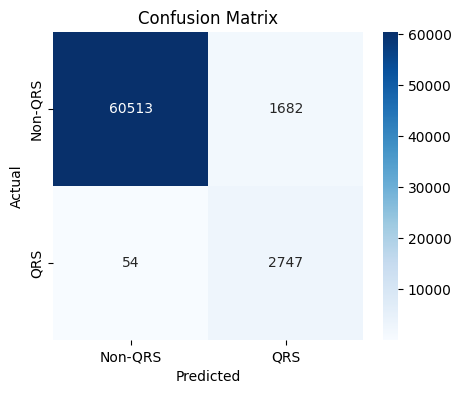

In [95]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(real_labels, predicted_labels.flatten())

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Non-QRS", "QRS"], yticklabels=["Non-QRS", "QRS"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


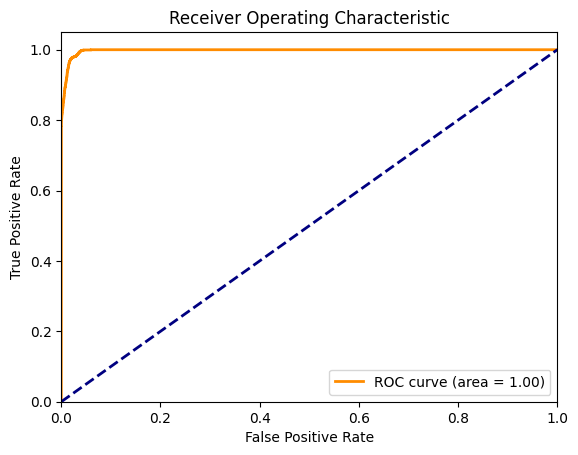

In [96]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(real_labels, predictions.flatten())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [97]:
import numpy as np
import matplotlib.pyplot as plt
def display_signal(start_second, end_second):
  # Define fixed-length window parameters
  window_size = 50  # Fixed window size (e.g., 250 samples)
  overlap = 40      # Overlap between windows (e.g., 50% overlap)
  half_window = window_size // 2  # Half window siz
  # Define sampling rate
  sampling_rate = 360  # Hz

  # Define zoom window in **seconds**
  zoom_start_sec = start_second   # Start time in seconds
  zoom_end_sec = end_second     # End time in seconds

  # Convert zoom window from seconds to samples
  zoom_start = zoom_start_sec * sampling_rate  # Convert to sample index
  zoom_end = zoom_end_sec * sampling_rate      # Convert to sample index

    # Function to filter windows within the zoom range (in sample indices)
  def filter_windows_in_zoom(windows, zoom_start, zoom_end):
      """Filter windows that fall within the zoom range in samples."""
      return [(start, end) for start, end in windows if start < zoom_end and end > zoom_start]

    # Identify segment start and end in samples
  positive_windows = [(new_start_segments[i], new_start_segments[i] + window_size) for i in range(len(predicted_labels)) if predicted_labels[i] == 1]
  negative_windows = [(new_start_segments[i], new_start_segments[i] + window_size) for i in range(len(predicted_labels)) if predicted_labels[i] == 0]
  print("Number of positive (QRS) segments:", len(positive_windows))
  print("Number of negative (non-QRS) segments:", len(negative_windows))
  # Filter positive and negative windows within the zoom range
  positive_windows_zoom = filter_windows_in_zoom(positive_windows, zoom_start, zoom_end)
  negative_windows_zoom = filter_windows_in_zoom(negative_windows, zoom_start, zoom_end)

  # Create time axis in **seconds**
  time_axis = np.arange(len(new_normalized_signal)) / sampling_rate  # Convert samples to seconds

  # Plot 1: Positive (QRS) Segments
  plt.figure(figsize=(12, 4))
  plt.plot(time_axis, new_normalized_signal, label="ECG Signal", color="blue")

    # Highlight positive (QRS) windows in red (only within the zoom range)
  for start, end in positive_windows_zoom:
    plt.axvspan(start / sampling_rate, end / sampling_rate, color="red", alpha=0.3, label="QRS Segment" if start == positive_windows_zoom[0][0] else "")

  plt.title(f"Positive (QRS) Segments (Window Size: {window_size} samples, Overlap: {overlap} samples)")
  plt.xlabel("Time (s)")
  plt.ylabel("Normalized Amplitude")
  plt.xlim(zoom_start_sec, zoom_end_sec)  # Zoom in on the time range
  plt.legend()
  plt.grid()
  plt.show()

    # Plot 2: Negative (Non-QRS) Segments
  plt.figure(figsize=(12, 4))
  plt.plot(time_axis, new_normalized_signal, label="ECG Signal", color="blue")

  # Highlight negative (non-QRS) windows in yellow (only within the zoom range)
  for start, end in negative_windows_zoom:
      plt.axvspan(start / sampling_rate, end / sampling_rate, color="yellow", alpha=0.3, label="Non-QRS Segment" if start == negative_windows_zoom[0][0] else "")
      #plt.vlines(start / sampling_rate, ymin=np.min(normalized_signal), ymax=np.max(normalized_signal), color="green", linestyle="dashed", alpha=0.6, label="Segment Start")

  plt.title(f"Negative (Non-QRS) Segments (Window Size: {window_size} samples, Overlap: {overlap} samples)")
  plt.xlabel("Time (s)")
  plt.ylabel("Normalized Amplitude")
  plt.xlim(zoom_start_sec, zoom_end_sec)  # Zoom in on the time range
  plt.legend()
  plt.grid()
  plt.show()


Number of positive (QRS) segments: 4429
Number of negative (non-QRS) segments: 60567


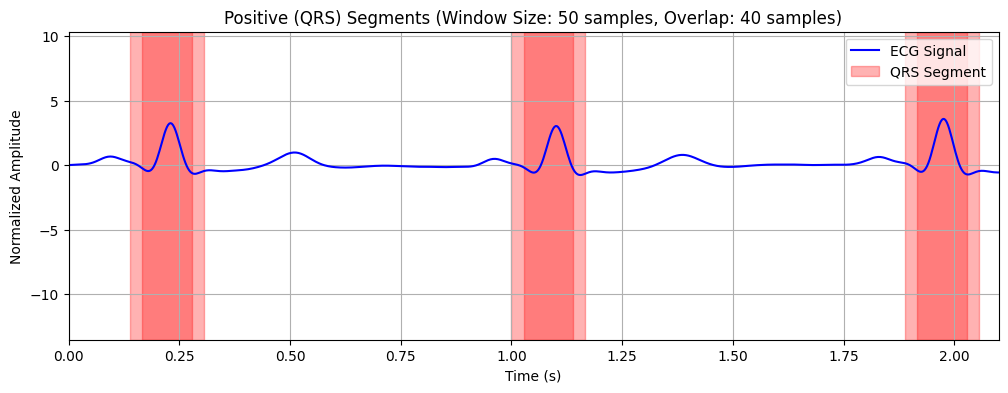

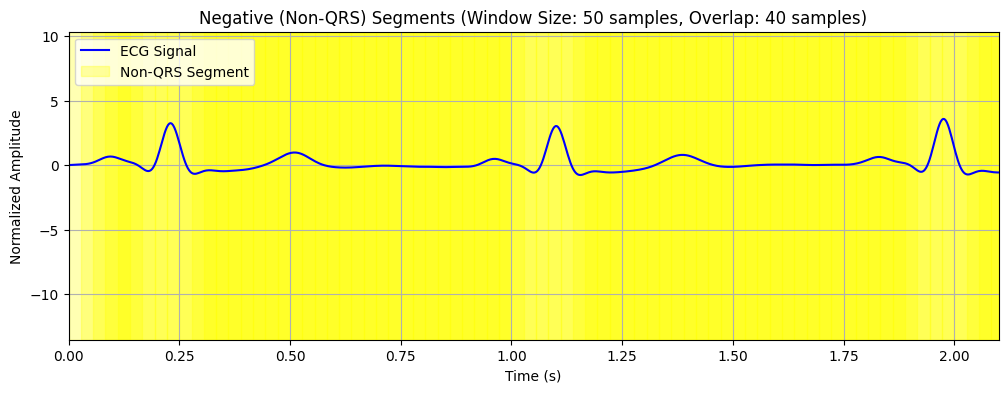

In [98]:
display_signal(0,2.1)

In [99]:
def remove_consecutive_ones(segment_labels, segmented_signal, segment_starts):
    filtered_labels = []
    filtered_signal = []
    filtered_starts = []

    i = 0
    while i < len(segment_labels)-1:
        if segment_labels[i] == 1:
            # Find the range of consecutive ones
            start = i
            while i + 1 < len(segment_labels) and segment_labels[i + 1] == 1:
                i += 1
            end = i

            # Compute the middle index of the block
            mid = (start + end) // 2

            # Keep only the middle one
            filtered_labels.append(segment_labels[mid])
            filtered_signal.append(segmented_signal[mid])
            filtered_starts.append(segment_starts[mid])

        else:
            # Keep zeros as they are
            filtered_labels.append(segment_labels[i])
            filtered_signal.append(segmented_signal[i])
            filtered_starts.append(segment_starts[i])

        i += 1  # Move to the next segment

    return filtered_labels, filtered_signal, filtered_starts


predicted_labels, new_segments, new_start_segments = remove_consecutive_ones(predicted_labels, new_segments, new_start_segments)

Number of positive (QRS) segments: 1869
Number of negative (non-QRS) segments: 60566


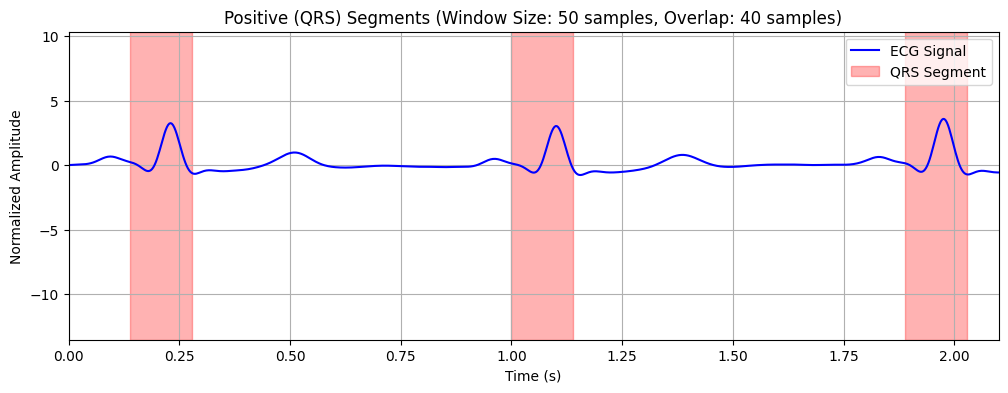

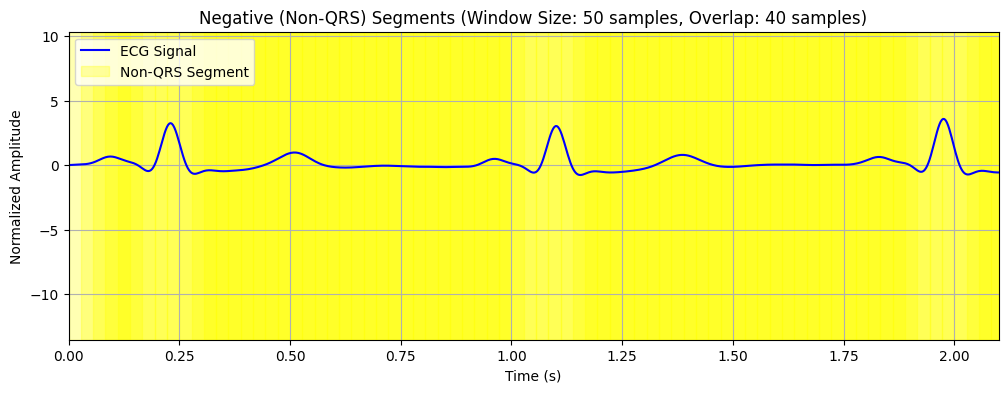

In [100]:
display_signal(0,2.1)

In [101]:
def remove_touching_negatives(segment_labels, segmented_signal, segment_starts):
    new_labels = segment_labels[:]  # Copy original lists
    new_signal = segmented_signal[:]
    new_starts = segment_starts[:]

    to_remove = set()  # Indices to remove

    for i, label in enumerate(segment_labels):
        if label == 1:  # If it's a positive window
            # Mark 4 windows before and after for removal
            for j in range(max(0, i - 4), min(len(segment_labels), i + 5)):
                if segment_labels[j] == 0:  # Only remove negatives
                    to_remove.add(j)

    # Remove marked indices
    new_labels = [label for i, label in enumerate(segment_labels) if i not in to_remove]
    new_signal = [signal for i, signal in enumerate(segmented_signal) if i not in to_remove]
    new_starts = [start for i, start in enumerate(segment_starts) if i not in to_remove]

    return new_labels, new_signal, new_starts

# Example usage:
predicted_labels, new_segments, new_start_segments = remove_touching_negatives(predicted_labels, new_segments, new_start_segments)



Number of positive (QRS) segments: 1869
Number of negative (non-QRS) segments: 45637


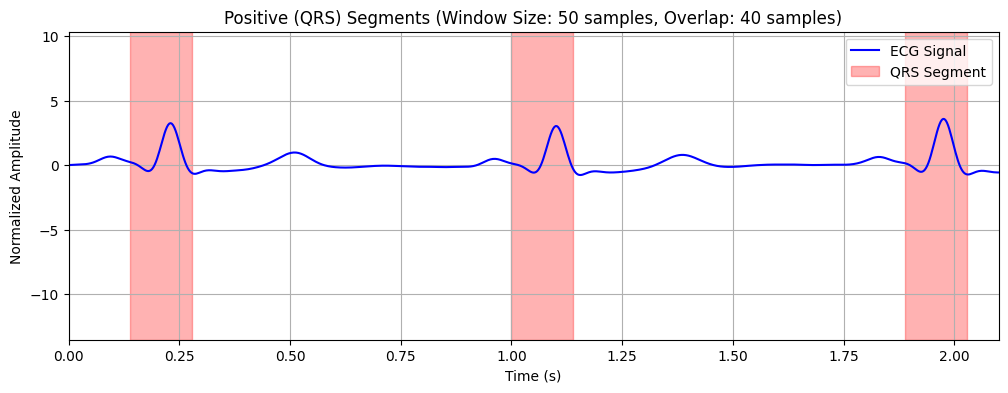

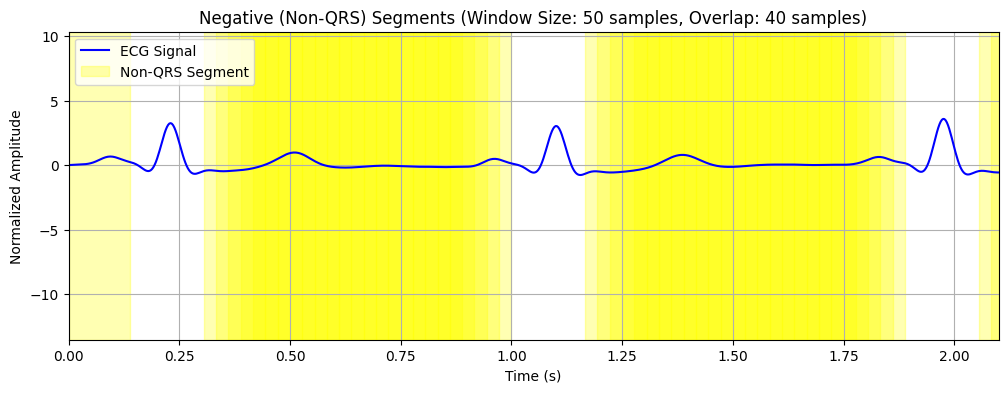

In [103]:
display_signal(0,2.1)